In [35]:
import six.moves
import itertools

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from statsmodels.tsa.statespace.sarimax import SARIMAX

def arima_process(size, ar_coefs, ma_coefs, d=0):
    """Simulate a series from an arima model."""
    arma = ArmaProcess(ar_coefs, ma_coefs)
    arma_series = arma.generate_sample(size + d)
    # Integrate d times.
    for i in six.moves.range(d):
        arma_series = np.cumsum(arma_series)
    return pd.Series(arma_series)

In [2]:
def plot_arima_process(ax, size, ar_coefs, ma_coefs, d=0):
    series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(series.index, series)

In [3]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

In [4]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

In [5]:
posts_df = pd.read_csv('../data/posts.csv')

In [6]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4584013 entries, 0 to 4584012
Data columns (total 5 columns):
id                   int64
date                 object
classroom_id         int64
picture_file_name    object
private              object
dtypes: int64(2), object(3)
memory usage: 174.9+ MB


In [7]:
# ar_coefs = [[0.5], [-0.5]]
# ma_coefs = [[0.5], [-0.5]]
# ds = [0, 1]

# fig, axs = plt.subplots(8, figsize=(14, 15))

# for ax, (ar, ma, d) in six.moves.zip(axs, itertools.product(ar_coefs, ma_coefs, ds)):
#     plot_arima_process(ax, 250, ar, ma, d)
#     ax.set_title("ARIMA Process with AR={}, MA={}, d={}".format(
#         str(list(ar)), str(list(ma)), d))
    
# plt.tight_layout()

In [8]:
posts_df['date'] = pd.to_datetime(posts_df['date'], errors='coerce')

In [9]:
count_posts_per_day_df = posts_df.groupby(['classroom_id', 'date']).count()
count_posts_per_day_df

id  picture_file_name  private
classroom_id date                                       
1            2011-12-25   16                 16       16
             2012-01-05   25                 11       25
             2012-01-06   16                  6       16
             2012-01-12   16                  4       16
             2012-01-13   22                 22       22
             2012-01-14    9                  0        9
             2012-01-17    7                  3        7
             2012-01-25   17                 11       17
             2012-01-26    7                  7        7
             2012-01-27   43                  2       43
             2012-01-30    4                  4        4
             2012-01-31    1                  1        1
             2012-02-01    6                  6        6
             2012-02-03    4                  4        4
             2012-02-04    3                  3        3
             2012-02-06   33                  0       33
             2012-02-07   10                  2       10
             2012-02-08    5                  5        5
             2012-02-09   42                 16       42
             2012-02-10    7                  0        7
             2012-02-11    3                  0        3
             2012-02-13    9                  0        9
             2012-02-14   12                  0       12
             2012-02-15   10                  6       10
             2012-02-16   13                  7       13
             2012-02-17    2                  1        2
             2012-02-21    8                  5        8
             2012-02-22   19                  8       19
             2012-02-23    3                  0        3
             2012-02-24   13                  2       13
...                      ...                ...      ...
3836         2018-02-20    3                  3        3
             2018-02-22    1                  1        1
             2018-02-28    1                  1        1
             2018-03-08    1                  1        1
             2018-03-09    2                  2        2
             2018-03-12    4                  0        4
             2018-03-13    1                  1        1
             2018-03-16   39                  0       39
3837         2018-03-13    5                  3        5
3838         2018-03-13   85                  0       85
             2018-03-14   79                  0       79
             2018-03-16   66                  0       66
             2018-03-17   69                  0       69
3840         2018-03-12   23                  0       23
3843         2017-11-21    9                  9        9
             2017-11-28    6                  6        6
             2017-11-29    3                  3        3
             2018-01-26    5                  5        5
             2018-02-15    3                  3        3
             2018-02-16   12                 12       12
             2018-03-13  222                 15      222
             2018-03-14  146                 54      146
             2018-03-15   66                 10       66
3849         2018-03-15   28                  0       28
             2018-03-16   23                  0       23
3859         2018-03-15    5                  3        5
             2018-03-16    1                  0        1
3860         2018-03-15   16                  1       16
             2018-03-16    2                  1        2
3862         2018-03-15    1                  0        1

[203159 rows x 3 columns]

In [10]:
count_posts_per_day_df.loc[1].head()

,id,picture_file_name,private
date,,,
2011-12-25,16,16,16
2012-01-05,25,11,25
2012-01-06,16,6,16
2012-01-12,16,4,16
2012-01-13,22,22,22


In [11]:
count_posts_per_day_df.loc[1].index


DatetimeIndex(['2011-12-25', '2012-01-05', '2012-01-06', '2012-01-12',
               '2012-01-13', '2012-01-14', '2012-01-17', '2012-01-25',
               '2012-01-26', '2012-01-27',
               ...
               '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10',
               '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15',
               '2018-03-16', '2018-03-18'],
              dtype='datetime64[ns]', name='date', length=1482, freq=None)

In [12]:
class_1_count_posts_by_date = pd.Series(count_posts_per_day_df.loc[1]['id'].values, 
                            count_posts_per_day_df.loc[1].index)

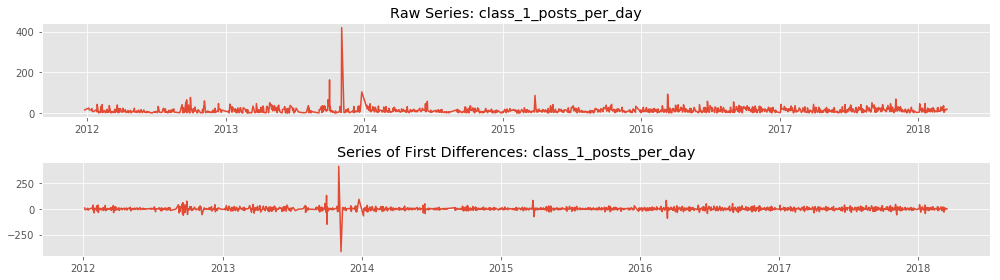

In [13]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, class_1_count_posts_by_date, "class_1_posts_per_day")
plt.tight_layout()

In [14]:
class_1_posts_diff = class_1_count_posts_by_date.diff()[1:]

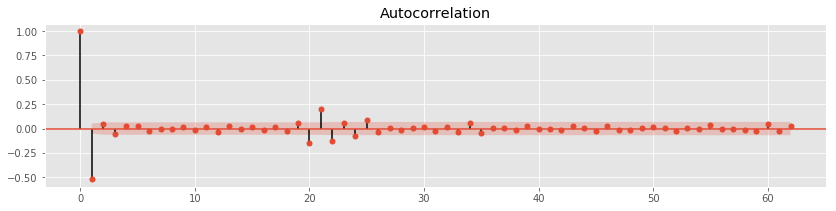

In [15]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(class_1_posts_diff, lags=62, ax=ax)

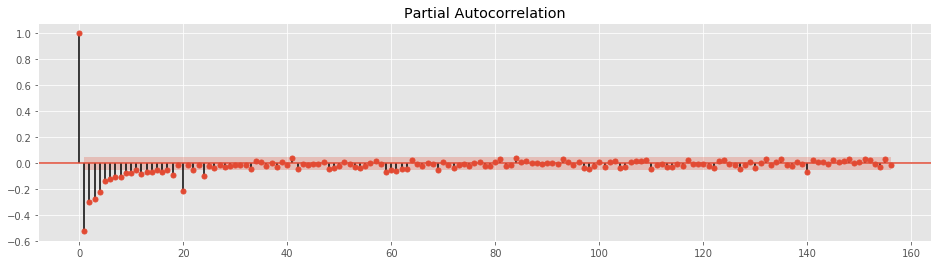

In [16]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(class_1_posts_diff, lags=3*52, ax=ax)

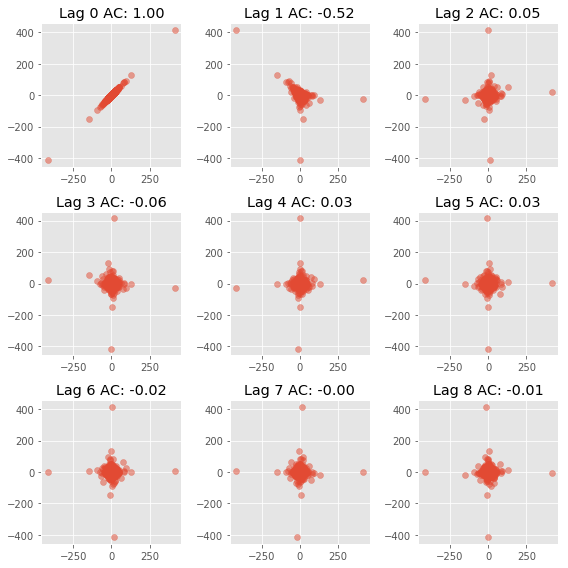

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    series, lagged = series_and_lagged(class_1_posts_diff, lag=i)
    autocorr = compute_autocorrelation(class_1_posts_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

In [18]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

In [19]:
np.dtype(class_1_count_posts_by_date)

dtype('int64')

In [20]:
class_1_count_posts_by_date = class_1_count_posts_by_date.astype('float64')
class_1_count_posts_by_date = class_1_count_posts_by_date.reindex(pd.date_range('09-01-2013', '2019', freq='D'), fill_value=0)

In [21]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [38]:
# model_class_1_posts_by_day = ARIMA(class_1_count_posts_by_date, order=(3, 1, 0)).fit()
model_class_1_posts_by_day = SARIMAX(class_1_count_posts_by_date, order=(1, 1, 0), seasonal_order=(1, 0, 0, 52)).fit()
print("ARIMA(3, 1, 0) coefficients from Electric model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    model_class_1_posts_by_day.params[0], 
        format_list_of_floats(list(model_class_1_posts_by_day.params[1:]))
    ))

ARIMA(3, 1, 0) coefficients from Electric model:
  Intercept -0.45
  AR ['-0.08', '291.78']


In [39]:
 model_class_1_posts_by_day

In [40]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(class_1_posts_diff.index, class_1_posts_diff)
ax[0].set_title("First Differences of Electric Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(class_1_posts_diff), 
                                             list(model_class_1_posts_by_day.params)[1:])
    simulated_data.index = class_1_posts_diff.index
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Electric Model Fit")
    
plt.tight_layout()

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2950: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
/Users/macbookpro/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:443: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)
/Users/macbookpro/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/macbookpro/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/macbookpro/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1773: RuntimeWarning: overflow encou

IndexError: index 0 is out of bounds for axis 0 with size 0

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x105e100d0> (for post_execute):


IndexError: index 0 is out of bounds for axis 0 with size 0

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1008x576 with 4 Axes>

In [41]:
# import pandas as pd

# idx = pd.date_range('09-01-2013', '09-30-2013')

# s = pd.Series({'09-02-2013': 2,
#                '09-03-2013': 10,
#                '09-06-2013': 5,
#                '09-07-2013': 1})
# s.index = pd.DatetimeIndex(s.index)

# s = s.reindex(idx, fill_value=0)

# class_1_count_posts_by_date

AttributeError: 'SARIMAXResults' object has no attribute 'plot_predict'

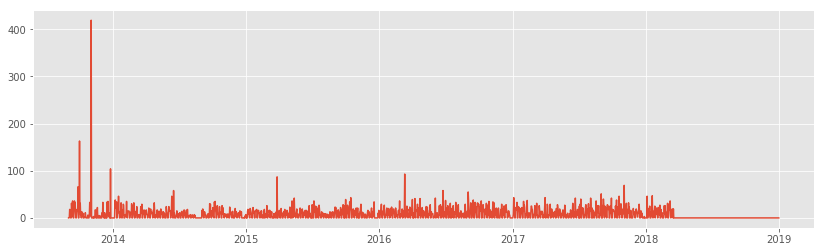

In [42]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(class_1_count_posts_by_date.index, class_1_count_posts_by_date)


fig = model_class_1_posts_by_day.plot_predict('2017-12-11', '2020', 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[0].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Electric Series Forcasts from ARIMA Model")
plt.show

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(model_class_1_posts_by_day.resid.index, model_class_1_posts_by_day.resid)
ax.set_title("Residuals from Electric Model")
plt.tight_layout()

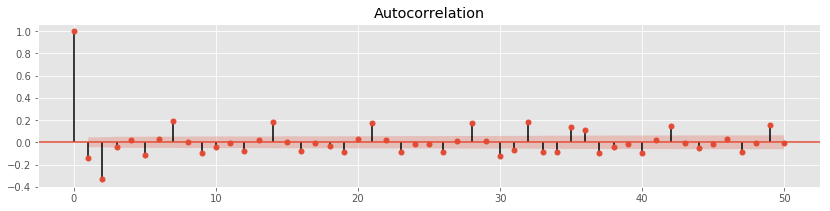

In [43]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(model_class_1_posts_by_day.resid, lags=50, ax=ax)

In [44]:
parameters = [
    {'AR': 3, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 4, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(class_1_count_posts_by_date, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(3, 1, 0) AIC: 16281.531189218853
ARIMA(2, 1, 0) AIC: 16427.488879793484
ARIMA(4, 1, 0) AIC: 16232.015914171527
ARIMA(3, 1, 1) AIC: 15850.427679718086


In [ ]:
# baseball_series.index = pd.DatetimeIndex(start='10-7-2011', end='9-25-2016', freq='d')
# baseball_series = baseball_series.reindex(pd.DatetimeIndex(
#         start='10-7-2011', end='2020', freq='W'))

Text(0.5,1,'Forecasts for Baseball Search Popularity')

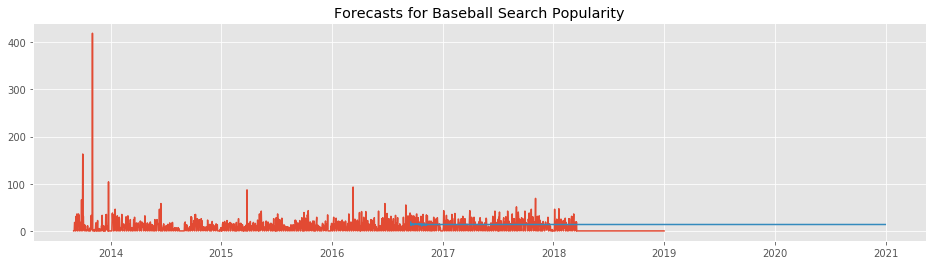

In [47]:
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(class_1_count_posts_by_date.index, class_1_count_posts_by_date)

preds = model_class_1_posts_by_day.predict('2018-09-17', '2020', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds)
ax.set_title("Forecasts for Baseball Search Popularity")